In [14]:
import os
import time
import chess
import chess.pgn

import numpy as np
import pathlib

In [131]:
#https://www.chessprogramming.org/Simplified_Evaluation_Function#Piece-Square_Tables

pawn_weights_w = np.array([
    [0,  0,  0,  0,  0,  0,  0,  0],
    [50, 50, 50, 50, 50, 50, 50, 50],
    [10, 10, 20, 30, 30, 20, 10, 10],
    [5,  5, 10, 25, 25, 10,  5,  5],
    [0,  0,  0, 20, 20,  0,  0,  0],
    [5, -5,-10,  0,  0,-10, -5,  5],
    [5, 10, 10,-20,-20, 10, 10,  5],
    [0,  0,  0,  0,  0,  0,  0,  0]
])
pawn_weights_b = np.flipud(pawn_weights_w)
    
knight_weights_w = np.array([
    [-50,-40,-30,-30,-30,-30,-40,-50],
    [-40,-20,  0,  0,  0,  0,-20,-40],
    [-30,  0, 10, 15, 15, 10,  0,-30],
    [-30,  5, 15, 20, 20, 15,  5,-30],
    [-30,  0, 15, 20, 20, 15,  0,-30],
    [-30,  5, 10, 15, 15, 10,  5,-30],
    [-40,-20,  0,  5,  5,  0,-20,-40],
    [-50,-40,-30,-30,-30,-30,-40,-50]
])
knight_weights_b = np.flipud(knight_weights_w)

bishop_weights_w = np.array([
    [-20,-10,-10,-10,-10,-10,-10,-20],
    [-10,  0,  0,  0,  0,  0,  0,-10],
    [-10,  0,  5, 10, 10,  5,  0,-10],
    [-10,  5,  5, 10, 10,  5,  5,-10],
    [-10,  0, 10, 10, 10, 10,  0,-10],
    [-10, 10, 10, 10, 10, 10, 10,-10],
    [-10,  5,  0,  0,  0,  0,  5,-10],
    [-20,-10,-10,-10,-10,-10,-10,-20]  
])
bishop_weights_b = np.flipud(bishop_weights_w)

rook_weights_w = np.array([
    [0,  0,  0,  0,  0,  0,  0,  0],
    [5, 10, 10, 10, 10, 10, 10,  5],
    [-5,  0,  0,  0,  0,  0,  0, -5],
    [-5,  0,  0,  0,  0,  0,  0, -5],
    [-5,  0,  0,  0,  0,  0,  0, -5],
    [-5,  0,  0,  0,  0,  0,  0, -5],
    [-5,  0,  0,  0,  0,  0,  0, -5],
    [0,  0,  0,  5,  5,  0,  0,  0]   
])
rook_weights_b = np.flipud(rook_weights_w)

queen_weights_w = np.array([
    [-20,-10,-10, -5, -5,-10,-10,-20],
    [-10,  0,  0,  0,  0,  0,  0,-10],
    [-10,  0,  5,  5,  5,  5,  0,-10],
    [-5,  0,  5,  5,  5,  5,  0, -5],
    [0,  0,  5,  5,  5,  5,  0, -5],
    [-10,  5,  5,  5,  5,  5,  0,-10],
    [-10,  0,  5,  0,  0,  0,  0,-10],
    [-20,-10,-10, -5, -5,-10,-10,-20]  
])
queen_weights_b = np.flipud(queen_weights_w)

king_weights_mid_w = np.array([
    [-30,-40,-40,-50,-50,-40,-40,-30],
    [-30,-40,-40,-50,-50,-40,-40,-30],
    [-30,-40,-40,-50,-50,-40,-40,-30],
    [-30,-40,-40,-50,-50,-40,-40,-30],
    [-20,-30,-30,-40,-40,-30,-30,-20],
    [-10,-20,-20,-20,-20,-20,-20,-10],
    [20, 20,  0,  0,  0,  0, 20, 20],
    [20, 30, 10,  0,  0, 10, 30, 20]
])
king_weights_mid_b = np.flipud(king_weights_mid_w)

king_weights_late_w = np.array([
    [-50,-40,-30,-20,-20,-30,-40,-50],
    [-30,-20,-10,  0,  0,-10,-20,-30],
    [-30,-10, 20, 30, 30, 20,-10,-30],
    [-30,-10, 30, 40, 40, 30,-10,-30],
    [-30,-10, 30, 40, 40, 30,-10,-30],
    [-30,-10, 20, 30, 30, 20,-10,-30],
    [-30,-30,  0,  0,  0,  0,-30,-30],
    [-50,-30,-30,-30,-30,-30,-30,-50] 
])
king_weights_late_b = np.flipud(king_weights_late_w)

weights_w = [pawn_weights_w, knight_weights_w, bishop_weights_w,
            rook_weights_w, queen_weights_w, king_weights_mid_w, king_weights_late_w]

weights_b = [pawn_weights_b, knight_weights_b, bishop_weights_b,
            rook_weights_b, queen_weights_b, king_weights_mid_b, king_weights_late_b]

PIECES_VALUES = [1, 3, 3, 5, 10, 0]

In [125]:
# Gets number indicating how strong the positioning of a given piece is
def get_piece_position_value(piece, i, j, moveNum, limit):
    if piece == None:
        return
    weights = []
    if piece.color == chess.WHITE:
        weights = weights_w
    elif piece.color == chess.BLACK:
        weights = weights_b
    else:
        print("Invalid color")
        return 0
    
    pt = piece.piece_type
    if pt == 6:
        if moveNum > limit:
            return weights[pt][i][j]
    return weights[pt-1][i][j] * PIECES_VALUES[pt-1]

# Gives number indicating how strong a given player's position is
def get_board_position_value(board, color, limit):
    if color != chess.BLACK and color != chess.WHITE:
        return
    sum_of_weights = 0
    count = 0
    for i in range(7,-1,-1):
        for j in range(7,-1,-1):
            res = 0
            piece = board.piece_at(chess.SQUARES[i * 8 + j])
            moveNum = board.fullmove_number
            if  piece != None and piece.color == color:
                res = get_piece_position_value(piece, i, j, moveNum, limit)
                count += 1
            if res != None:
                sum_of_weights += res
    return sum_of_weights / count

In [126]:
'''
Reads in GAMES_LIMIT games from the input file and calculates
some very basic features. Outputs the features in x.csv, and
outputs into y.csv.
'''

# Global variables
GAMES_LIMIT = 1000

pgn = open(f'../data/fics_202011_notime_50k.pgn')
games = []
for i in range(GAMES_LIMIT):
    game = chess.pgn.read_game(pgn)
    games.append(game)

In [137]:
MOVES_LIMIT = 50

elo = []
position = []

for j in range(GAMES_LIMIT):
    game = games[j]
    board = game.board()
    
    position_values = []
    i = 0
    for move in game.mainline_moves():
        if i >= MOVES_LIMIT:
            break
        board.push(move)
        position_values.append(get_board_position_value(board, chess.WHITE, 0.66 * int(game.headers['PlyCount'])))
        i += 1

    pos_diffs = []
    for i in range(1, len(position_values)):
        pos_diffs.append(position_values[i] - position_values[i-1])
    
    if len(pos_diffs) > 0:
        position.append(np.min(pos_diffs))
        elo.append(game.headers['WhiteElo'])

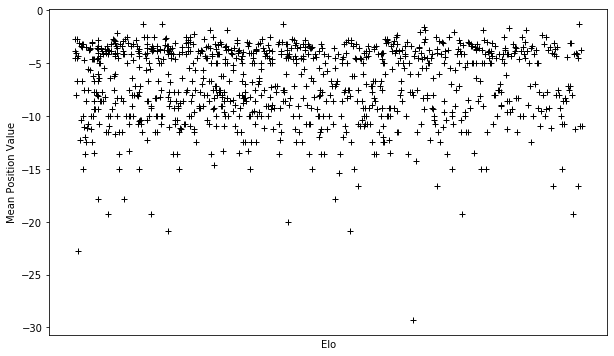

In [138]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression


plt.scatter(elo, position, color='black', marker='+', linewidth=1)
plt.xlabel('Elo')
plt.ylabel('Mean Position Value')
plt.xticks(range(0))
plt.gcf().set_size_inches(10, 6)
plt.show()